# 🔬 Lab: YOLO26 + Depth Estimation
## Combining Object Detection with Monocular Depth Estimation

**Objectives:**
1. Understand Depth Estimation principles (Monocular Depth Estimation)
2. Use YOLO26 for Object Detection
3. Use MiDaS for Depth Estimation
4. Combine YOLO26 + MiDaS to estimate object distance from camera
5. Use Object Size-based Distance Estimation (YOLO BBox heuristics)
6. Create 3D-aware Visualizations

**Tools:**
- Ultralytics YOLO26 (Object Detection)
- Intel MiDaS (Monocular Depth Estimation)
- OpenCV, Matplotlib, NumPy

---

## Part 1: Depth Estimation Theory

### What is Depth Estimation?

**Depth Estimation** is the process of estimating the distance of each pixel in an image from the camera.
The result is a **Depth Map** where pixel intensity represents distance.

### Types of Depth Estimation

| Type | Description | Pros | Cons |
|------|------------|------|------|
| **Stereo Vision** | Uses 2 cameras, computes from disparity | Accurate | Requires 2 cameras |
| **LiDAR / ToF** | Uses laser light to measure distance | Very accurate | Expensive, specialized hardware |
| **Monocular Depth** | Uses single image + Deep Learning | Works with normal camera | Gives relative depth only |

### MiDaS (Multiple Depth from a Single Image)

MiDaS is a model from Intel Labs using Encoder-Decoder architecture:
- **Encoder**: ResNet / DPT (Dense Prediction Transformer) for feature extraction
- **Decoder**: Upsampling + Feature Fusion to create depth map
- Trained on 12+ datasets → works well with diverse image types

### Concept: YOLO + Depth Estimation

```
Input Image
   ├── YOLO26 → Bounding Boxes + Class Labels (2D Detection)
   ├── MiDaS  → Depth Map (distance per pixel)
   └── BBox Size Heuristic → Estimated distance from known object sizes
        ↓
   Combined → Each object + estimated distance (Pseudo-3D)
```

### Object Distance Estimation using BBox Size

In addition to MiDaS depth maps, we can estimate distance using a simple
**pinhole camera model** heuristic:


```
Distance ≈ (Known Real Height × Focal Length) / BBox Height in Pixels
```

This approach uses the fact that objects appear smaller when farther away.
By assuming typical real-world sizes for known COCO classes (e.g., a person
is ~1.7m tall), we can convert bounding box pixel height into an approximate
metric distance (in meters). This complements MiDaS relative depth with
an absolute distance estimate.

## Part 2: Install Libraries

In [1]:
# Install required libraries (uncomment if needed)
#!uv pip install ultralytics timm

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.10.0+cu130
CUDA available: True
GPU: NVIDIA GeForce RTX 5090
Using device: cuda


## Part 3: YOLO26 Object Detection

YOLO26 is the latest model from Ultralytics (2025) with key features:
- **NMS-Free**: No Non-Maximum Suppression needed → faster inference
- **DFL Removed**: Removed Distribution Focal Loss → easier deployment
- **Edge Optimized**: 43% faster CPU inference
- Supports: Detection, Segmentation, Pose, OBB, Classification

In [2]:
from ultralytics import YOLO

# Load YOLO26 nano model (pretrained on COCO dataset — 80 classes)
model = YOLO("yolo26n.pt")

# Run inference on image
IMAGE_PATH = ".././images/football_teamplay.jpeg"
results = model(IMAGE_PATH, imgsz=640)


image 1/1 /home/workspace/DL-FOR-COMPUTER-VISION/week07/../images/football_teamplay.jpeg: 448x640 6 persons, 1 sports ball, 61.2ms
Speed: 1.0ms preprocess, 61.2ms inference, 20.3ms postprocess per image at shape (1, 3, 448, 640)


In [6]:
# ============================================================
# Assign persistent Object IDs at the FIRST detection
# These IDs will be used consistently throughout the entire lab
# ============================================================
result = results[0]

# Build a master object registry with stable IDs
OBJECT_REGISTRY = []
for i, box in enumerate(result.boxes):
    cls_id = int(box.cls[0])
    cls_name = result.names[cls_id]
    conf = float(box.conf[0])
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    OBJECT_REGISTRY.append({
        "obj_id": i,           # ← stable ID used everywhere
        "class": cls_name,
        "class_id": cls_id,
        "confidence": conf,
        "bbox": (int(x1), int(y1), int(x2), int(y2)),
        "bbox_area": int((x2 - x1) * (y2 - y1)),
        "center_x": int((x1 + x2) / 2),
        "center_y": int((y1 + y2) / 2),
        "bbox_width": int(x2 - x1),
        "bbox_height": int(y2 - y1),
    })

print("=" * 70)
print("  YOLO26 Detection Results — Master Object Registry")
print("=" * 70)
print(f"  Total objects detected : {len(OBJECT_REGISTRY)}")
print(f"  Image size             : {result.orig_shape}")
print(f"  Unique classes         : {result.boxes.cls.unique().tolist()}")
print()
print(f"  {'ID':>4} {'Class':>12} {'Conf':>6} {'BBox (x1,y1,x2,y2)':>28} {'Area':>8}")
print("  " + "-" * 66)
for obj in OBJECT_REGISTRY:
    x1, y1, x2, y2 = obj["bbox"]
    print(f"  {obj['obj_id']:>4} {obj['class']:>12} {obj['confidence']:>6.2f} "
          f"  ({x1:>4},{y1:>4},{x2:>4},{y2:>4}) {obj['bbox_area']:>8}")

print()
print("  These Object IDs will be referenced throughout the lab.")

  YOLO26 Detection Results — Master Object Registry
  Total objects detected : 7
  Image size             : (750, 1123)
  Unique classes         : [0.0, 32.0]

    ID        Class   Conf           BBox (x1,y1,x2,y2)     Area
  ------------------------------------------------------------------
     0       person   0.92   ( 588, 148, 762, 642)    85748
     1       person   0.91   ( 178, 212, 296, 580)    43345
     2       person   0.90   ( 281, 254, 396, 507)    29016
     3       person   0.90   ( 471, 278, 583, 489)    23618
     4       person   0.86   ( 745, 226, 810, 495)    17463
     5       person   0.85   ( 780, 170, 890, 536)    40505
     6  sports ball   0.81   ( 537, 491, 590, 546)     2941

  These Object IDs will be referenced throughout the lab.


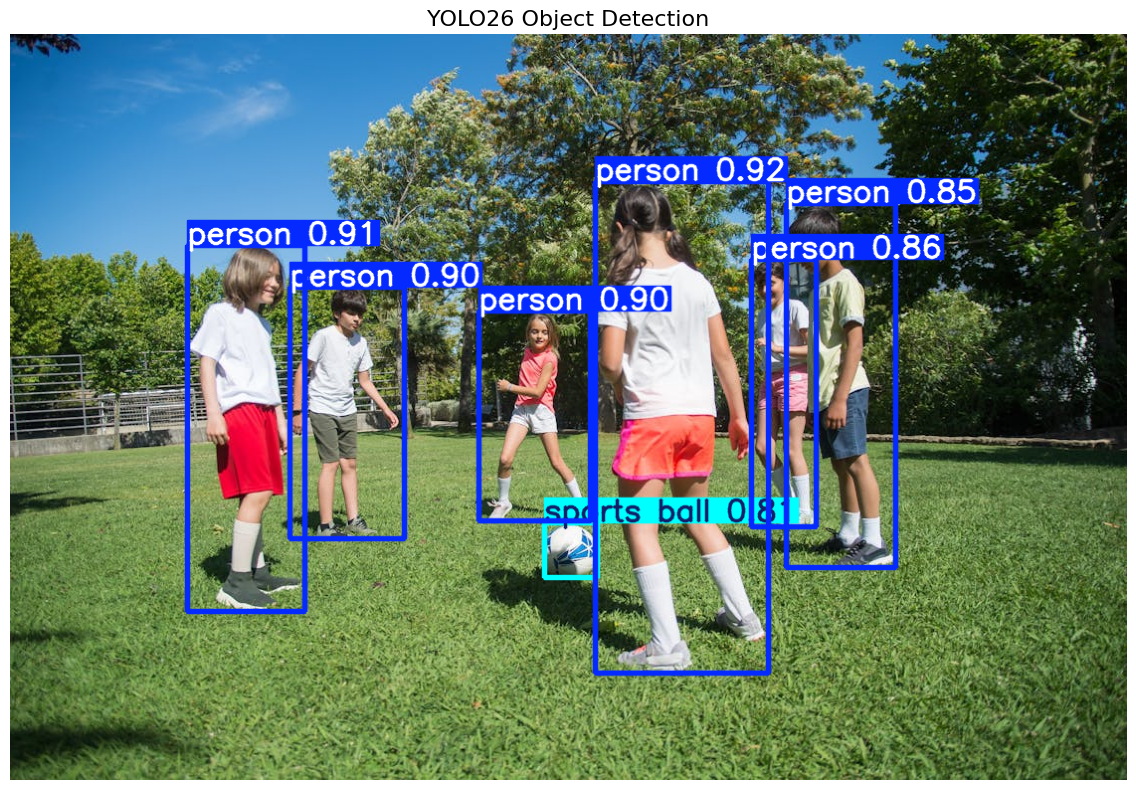

In [7]:
# Visualize YOLO26 detection
annotated_img = result.plot()
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(annotated_img_rgb)
plt.title("YOLO26 Object Detection", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

## Part 4: Object Distance Estimation using YOLO BBox Size

### Pinhole Camera Model Heuristic

Before using a depth model, we can get a rough **metric distance** estimate
by exploiting a simple geometric relationship:

```
Estimated Distance (m) = (Real World Height × Focal Length) / BBox Height (px)
```

We use typical real-world heights for common COCO classes and an assumed
focal length. This gives **absolute distance in meters** (unlike MiDaS
which only gives relative depth).

**Limitations:**
- Assumes the object is upright and fully visible
- Focal length is estimated (not calibrated)
- Works best for objects with known/consistent real-world sizes

**Advantages:**
- No extra model needed — uses only YOLO detection output
- Gives metric distance (meters) instead of relative values
- Very fast — just arithmetic on bounding box dimensions

In [8]:
# ==============================================================
# Known real-world heights (meters) for common COCO classes
# Used for pinhole-model distance estimation
# ==============================================================
KNOWN_HEIGHTS_M = {
    "person": 1.70,
    "bicycle": 1.10,
    "car": 1.50,
    "motorcycle": 1.20,
    "bus": 3.00,
    "truck": 3.50,
    "dog": 0.50,
    "cat": 0.30,
    "chair": 0.90,
    "bottle": 0.25,
    "cup": 0.12,
    "tv": 0.60,
    "laptop": 0.30,
    "cell phone": 0.14,
    "sports ball": 0.22,
    "backpack": 0.50,
    "umbrella": 1.00,
    "handbag": 0.35,
    "suitcase": 0.70,
    "bench": 0.85,
    "bird": 0.20,
    "horse": 1.60,
    "sheep": 0.80,
    "cow": 1.40,
    "elephant": 3.00,
    "bear": 1.50,
    "zebra": 1.40,
    "giraffe": 5.50,
}

# Default height for classes not in the table
DEFAULT_HEIGHT_M = 0.50

# Assumed focal length in pixels (rough estimate for a typical camera)
# For more accurate results, calibrate your camera.
ASSUMED_FOCAL_LENGTH_PX = 800


def estimate_distance_from_bbox(objects, focal_length=ASSUMED_FOCAL_LENGTH_PX):
    """
    Estimate metric distance (meters) from bounding box height
    using the pinhole camera model heuristic.

    Parameters:
    -----------
    objects : list of dict — object registry entries
    focal_length : float — estimated focal length in pixels

    Returns:
    --------
    list of dict — same objects with 'estimated_distance_m' added
    """
    for obj in objects:
        real_height = KNOWN_HEIGHTS_M.get(obj["class"], DEFAULT_HEIGHT_M)
        bbox_h = obj["bbox_height"]

        if bbox_h > 0:
            distance_m = (real_height * focal_length) / bbox_h
        else:
            distance_m = float("inf")

        obj["real_height_m"] = real_height
        obj["estimated_distance_m"] = round(distance_m, 2)

    return objects

In [9]:
# Apply distance estimation to all detected objects
OBJECT_REGISTRY = estimate_distance_from_bbox(OBJECT_REGISTRY)

# Sort by estimated distance (nearest first)
objects_by_distance = sorted(OBJECT_REGISTRY, key=lambda x: x["estimated_distance_m"])

print("=" * 80)
print("  Object Distance Estimation (Pinhole Camera Model)")
print("=" * 80)
print(f"  Assumed focal length: {ASSUMED_FOCAL_LENGTH_PX} px")
print()
print(f"  {'ID':>4} {'Class':>12} {'BBox H(px)':>10} {'Real H(m)':>10} {'Est. Dist(m)':>13}")
print("  " + "-" * 55)
for obj in objects_by_distance:
    print(f"  {obj['obj_id']:>4} {obj['class']:>12} {obj['bbox_height']:>10} "
          f"{obj['real_height_m']:>10.2f} {obj['estimated_distance_m']:>13.2f}")

  Object Distance Estimation (Pinhole Camera Model)
  Assumed focal length: 800 px

    ID        Class BBox H(px)  Real H(m)  Est. Dist(m)
  -------------------------------------------------------
     0       person        493       1.70          2.76
     6  sports ball         55       0.22          3.20
     1       person        368       1.70          3.70
     5       person        366       1.70          3.72
     4       person        269       1.70          5.06
     2       person        252       1.70          5.40
     3       person        211       1.70          6.45


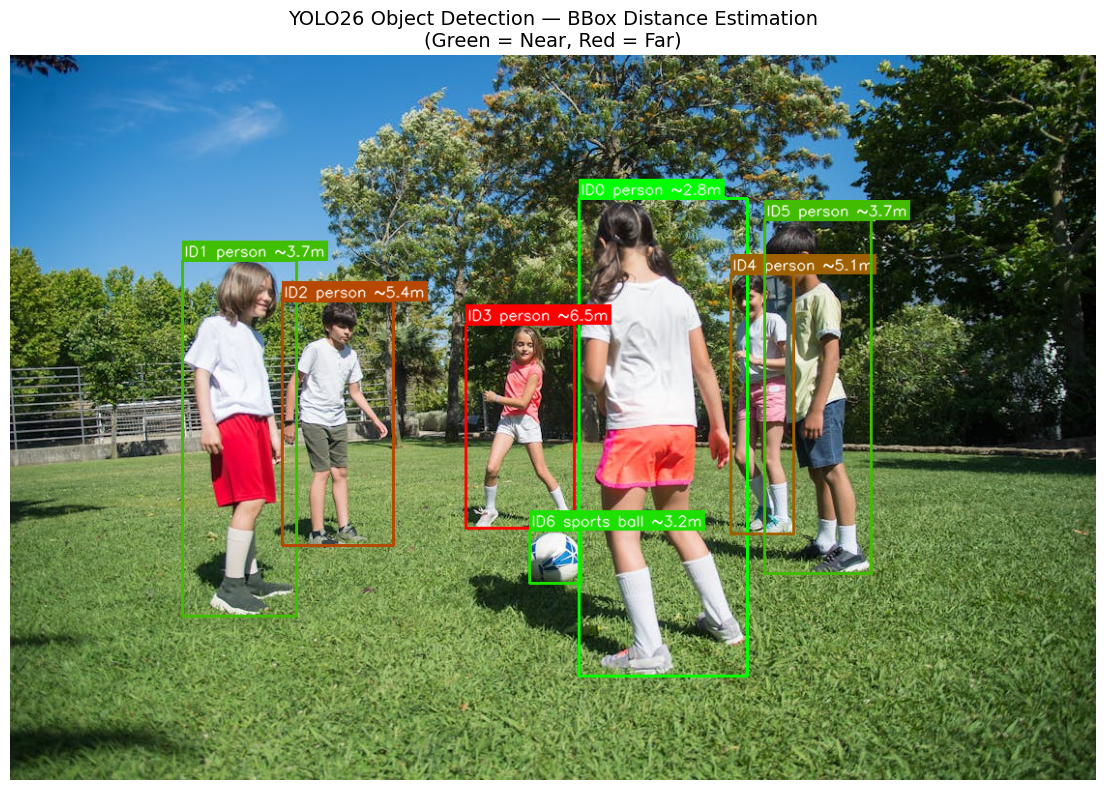

In [11]:
# Visualize BBox-based distance estimation on the image
def draw_distance_annotated_image(image_rgb, objects):
    """
    Draw bounding boxes with metric distance labels on the image.
    Color: green (near) → red (far)
    """
    img_out = image_rgb.copy()
    distances = [o["estimated_distance_m"] for o in objects if o["estimated_distance_m"] < float("inf")]
    if not distances:
        return img_out
    d_min, d_max = min(distances), max(distances)
    d_range = d_max - d_min if d_max > d_min else 1.0

    for obj in objects:
        x1, y1, x2, y2 = obj["bbox"]
        dist = obj["estimated_distance_m"]
        norm = min(1.0, (dist - d_min) / d_range)
        r, g, b = int(255 * norm), int(255 * (1 - norm)), 0
        color = (r, g, b)

        cv2.rectangle(img_out, (x1, y1), (x2, y2), color, 2)
        label = f"ID{obj['obj_id']} {obj['class']} ~{dist:.1f}m"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img_out, (x1, y1 - th - 8), (x1 + tw + 4, y1), color, -1)
        cv2.putText(img_out, label, (x1 + 2, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return img_out


img_bgr = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dist_annotated = draw_distance_annotated_image(img_rgb, OBJECT_REGISTRY)

plt.figure(figsize=(12, 8))
plt.imshow(dist_annotated)
plt.title("YOLO26 Object Detection — BBox Distance Estimation\n(Green = Near, Red = Far)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

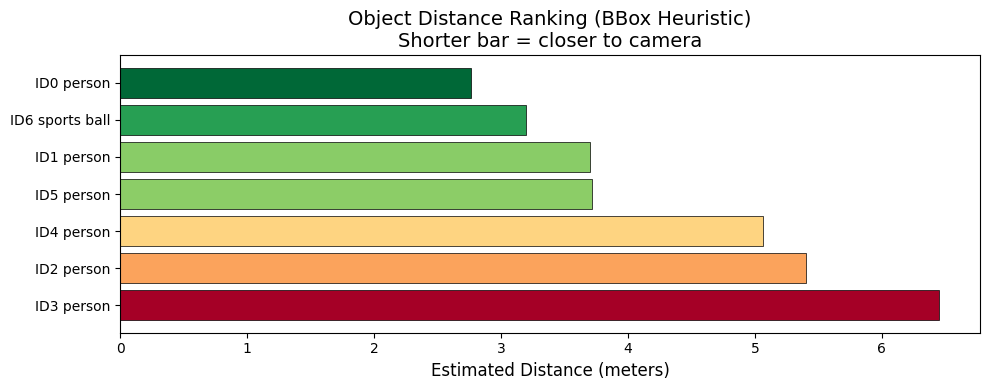

In [13]:
# Bar chart: Estimated distance per object
if OBJECT_REGISTRY:
    sorted_objs = sorted(OBJECT_REGISTRY, key=lambda x: x["estimated_distance_m"])
    labels = [f"ID{o['obj_id']} {o['class']}" for o in sorted_objs]
    dists = [o["estimated_distance_m"] for o in sorted_objs]
    d_min, d_max = min(dists), max(dists)
    d_range = d_max - d_min if d_max > d_min else 1.0
    colors = [plt.cm.RdYlGn_r((d - d_min) / d_range) for d in dists]

    fig, ax = plt.subplots(figsize=(10, max(4, len(labels) * 0.4)))
    ax.barh(labels, dists, color=colors, edgecolor="black", linewidth=0.5)
    ax.set_xlabel("Estimated Distance (meters)", fontsize=12)
    ax.set_title("Object Distance Ranking (BBox Heuristic)\nShorter bar = closer to camera", fontsize=14)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

## Part 5: MiDaS Depth Estimation

### MiDaS Model Variants

| Model | Size | Accuracy | Speed |
|-------|------|----------|-------|
| **DPT_Large** | Large | Highest | Slowest |
| **DPT_Hybrid** | Medium | Medium | Medium |
| **MiDaS_small** | Small | Lowest | Fastest |

> ⚠️ MiDaS gives **relative depth** (not absolute in meters).
> Higher value = farther from camera, Lower value = closer (inverse depth).

In [14]:
# Load MiDaS model from PyTorch Hub
# Choose model_type: "DPT_Large", "DPT_Hybrid", "MiDaS_small"

model_type = "DPT_Large"  # Start with small model (fast, low RAM)

print(f"Loading MiDaS model: {model_type}...")
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()
print(f"MiDaS loaded successfully! (device: {device})")

# Load transform for preprocessing
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type in ["DPT_Large", "DPT_Hybrid"]:
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

print(f"Transform loaded successfully!")

Loading MiDaS model: DPT_Large...


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


MiDaS loaded successfully! (device: cuda)
Transform loaded successfully!


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [15]:
# Read image and perform Depth Estimation
img_bgr = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Preprocessing: transform image
input_batch = transform(img_rgb).to(device)
print(f"Input shape: {input_batch.shape}")

# Inference
with torch.no_grad():
    prediction = midas(input_batch)
    # Resize depth map to match original image size
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()
print(f"Depth map shape: {depth_map.shape}")
print(f"Depth range: [{depth_map.min():.2f}, {depth_map.max():.2f}]")

Input shape: torch.Size([1, 3, 384, 576])
Depth map shape: (750, 1123)
Depth range: [-2.94, 37.80]


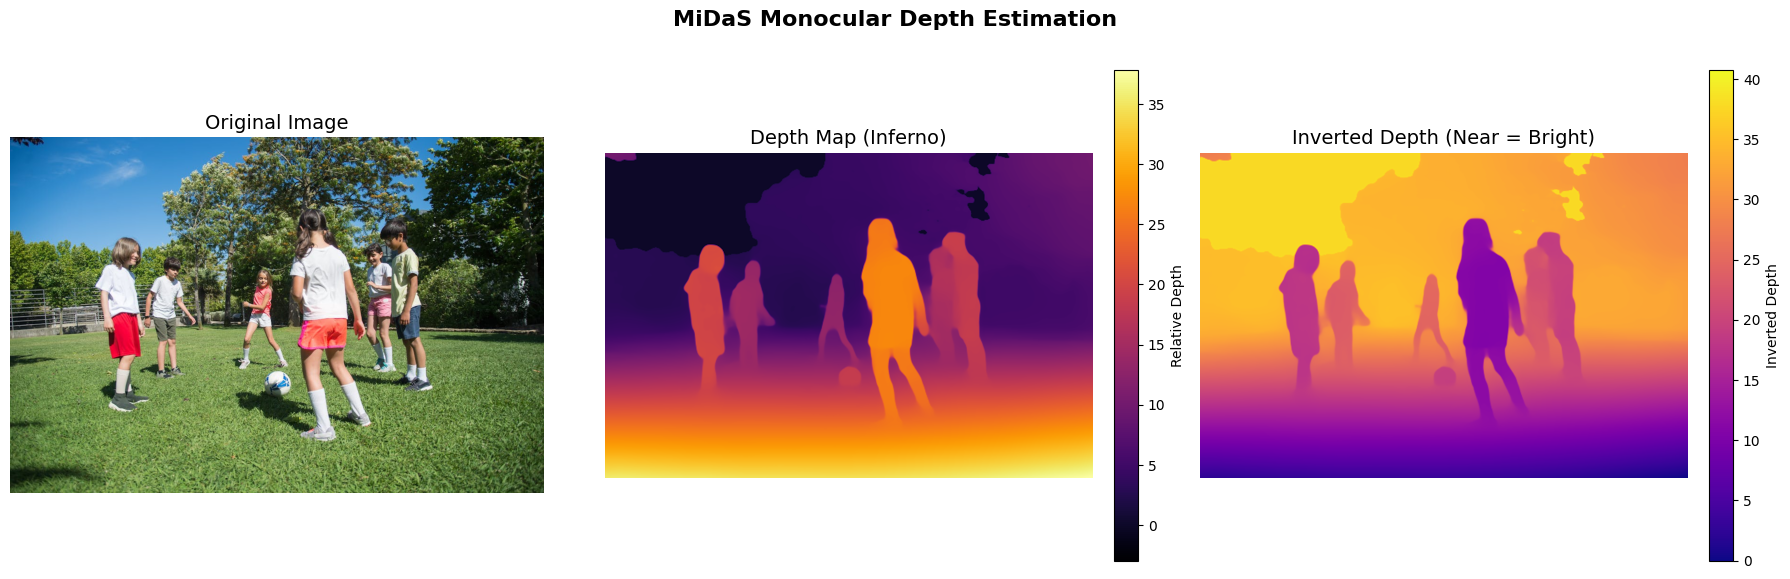

In [16]:
# Visualize Depth Map
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(img_rgb)
axes[0].set_title("Original Image", fontsize=14)
axes[0].axis("off")

# Depth Map (Inferno colormap)
im1 = axes[1].imshow(depth_map, cmap="inferno")
axes[1].set_title("Depth Map (Inferno)", fontsize=14)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Relative Depth")

# Depth Map inverted (near = bright)
depth_inv = depth_map.max() - depth_map
im2 = axes[2].imshow(depth_inv, cmap="plasma")
axes[2].set_title("Inverted Depth (Near = Bright)", fontsize=14)
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label="Inverted Depth")

plt.suptitle("MiDaS Monocular Depth Estimation", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## Part 6: Combine YOLO26 + MiDaS Depth Estimation

### Concept
1. Use YOLO26 to detect objects → get bounding boxes
2. Use MiDaS to generate depth map
3. For each bounding box → crop depth map region → compute average depth
4. Average depth = relative distance of object from camera
5. Rank: which objects are nearest / farthest

In [17]:
def estimate_object_depth(boxes, depth_map, names, method="median"):
    """
    Compute depth of each detected object using MiDaS depth map.

    Parameters:
    -----------
    boxes : ultralytics Boxes object
    depth_map : numpy array — depth map from MiDaS
    names : dict — class names mapping
    method : str — depth computation method ("mean", "median", "center")

    Returns:
    --------
    list of dict — each object info with depth (includes depth_normalized)
    """
    objects_with_depth = []

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls_id = int(box.cls[0])
        cls_name = names[cls_id]
        conf = float(box.conf[0])

        # Clamp to image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(depth_map.shape[1], x2)
        y2 = min(depth_map.shape[0], y2)

        # Crop depth region by bounding box
        depth_region = depth_map[y1:y2, x1:x2]

        if depth_region.size == 0:
            continue

        # Compute depth using selected method
        if method == "mean":
            obj_depth = np.mean(depth_region)
        elif method == "median":
            obj_depth = np.median(depth_region)
        elif method == "center":
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            obj_depth = depth_map[cy, cx]
        else:
            obj_depth = np.mean(depth_region)

        objects_with_depth.append({
            "obj_id": i,            # matches OBJECT_REGISTRY id
            "class": cls_name,
            "confidence": conf,
            "bbox": (x1, y1, x2, y2),
            "depth_value": obj_depth,
            "depth_std": np.std(depth_region),
            "bbox_area": (x2 - x1) * (y2 - y1),
        })

    # Sort by depth (MiDaS: higher value = farther)
    objects_with_depth.sort(key=lambda x: x["depth_value"])

    # ==================== BUG FIX ====================
    # Normalize depth to 0-100 so downstream functions
    # (draw_depth_annotated_image, compute_danger_score, etc.)
    # always have 'depth_normalized' available — including
    # when called from process_video_with_depth().
    # =================================================
    if objects_with_depth:
        depths = [o["depth_value"] for o in objects_with_depth]
        d_min, d_max = min(depths), max(depths)
        for o in objects_with_depth:
            if d_max > d_min:
                o["depth_normalized"] = (o["depth_value"] - d_min) / (d_max - d_min) * 100
            else:
                o["depth_normalized"] = 50.0

    return objects_with_depth

In [18]:
# Compute depth of each object
objects = estimate_object_depth(result.boxes, depth_map, result.names, method="median")

# Merge BBox-based distance into depth results for cross-reference
for obj in objects:
    registry_match = next((r for r in OBJECT_REGISTRY if r["obj_id"] == obj["obj_id"]), None)
    if registry_match:
        obj["estimated_distance_m"] = registry_match.get("estimated_distance_m", None)

# Display results
print("=" * 95)
print("  YOLO26 + MiDaS Depth Estimation Results (with BBox Distance)")
print("=" * 95)
print(f"  {'ID':>4} {'Class':>12} {'Conf':>6} {'MiDaS Depth':>12} {'Norm%':>8} "
      f"{'BBox Dist(m)':>13} {'Zone':>10}")
print("  " + "-" * 90)

for rank, obj in enumerate(objects, 1):
    zone = "NEAR" if obj["depth_normalized"] < 33 else "MID" if obj["depth_normalized"] < 66 else "FAR"
    zone_icon = {"NEAR": "[NEAR]", "MID": "[MID]", "FAR": "[FAR]"}[zone]
    bbox_dist_str = f"{obj['estimated_distance_m']:.2f}" if obj.get("estimated_distance_m") else "N/A"
    print(f"  {obj['obj_id']:>4} {obj['class']:>12} {obj['confidence']:>6.2f} "
          f"{obj['depth_value']:>12.2f} {obj['depth_normalized']:>7.1f}% "
          f"{bbox_dist_str:>13} {zone_icon:>10}")

  YOLO26 + MiDaS Depth Estimation Results (with BBox Distance)
    ID        Class   Conf  MiDaS Depth    Norm%  BBox Dist(m)       Zone
  ------------------------------------------------------------------------------------------
     3       person   0.90         8.82     0.0%          6.45     [NEAR]
     2       person   0.90        11.94    20.5%          5.40     [NEAR]
     4       person   0.86        15.36    43.0%          5.06      [MID]
     5       person   0.85        16.27    49.0%          3.72      [MID]
     6  sports ball   0.81        18.31    62.4%          3.20      [MID]
     1       person   0.91        18.81    65.7%          3.70      [MID]
     0       person   0.92        24.03   100.0%          2.76      [FAR]


## Part 7: Visualization — Annotated Image with Depth

Create image showing both bounding boxes and distance of each object.

In [19]:
def draw_depth_annotated_image(image_rgb, objects, depth_map):
    """
    Draw bounding boxes with depth annotation on image.
    Box color changes by depth (near = green, far = red).
    """
    img_annotated = image_rgb.copy()

    for obj in objects:
        x1, y1, x2, y2 = obj["bbox"]
        norm = obj["depth_normalized"] / 100.0  # 0 = near, 1 = far

        # Color: near = green (0,255,0), far = red (255,0,0)
        r = int(255 * norm)
        g = int(255 * (1 - norm))
        b = 0
        color = (r, g, b)

        # Draw bounding box
        cv2.rectangle(img_annotated, (x1, y1), (x2, y2), color, 2)

        # Label: ID + class + depth
        dist_str = f"~{obj['estimated_distance_m']:.1f}m" if obj.get("estimated_distance_m") else ""
        label = f"ID{obj['obj_id']} {obj['class']} D:{obj['depth_normalized']:.0f}% {dist_str}"

        # Background for text
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.45, 1)
        cv2.rectangle(img_annotated, (x1, y1 - th - 8), (x1 + tw + 4, y1), color, -1)

        # White text
        cv2.putText(img_annotated, label, (x1 + 2, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1, cv2.LINE_AA)

    return img_annotated

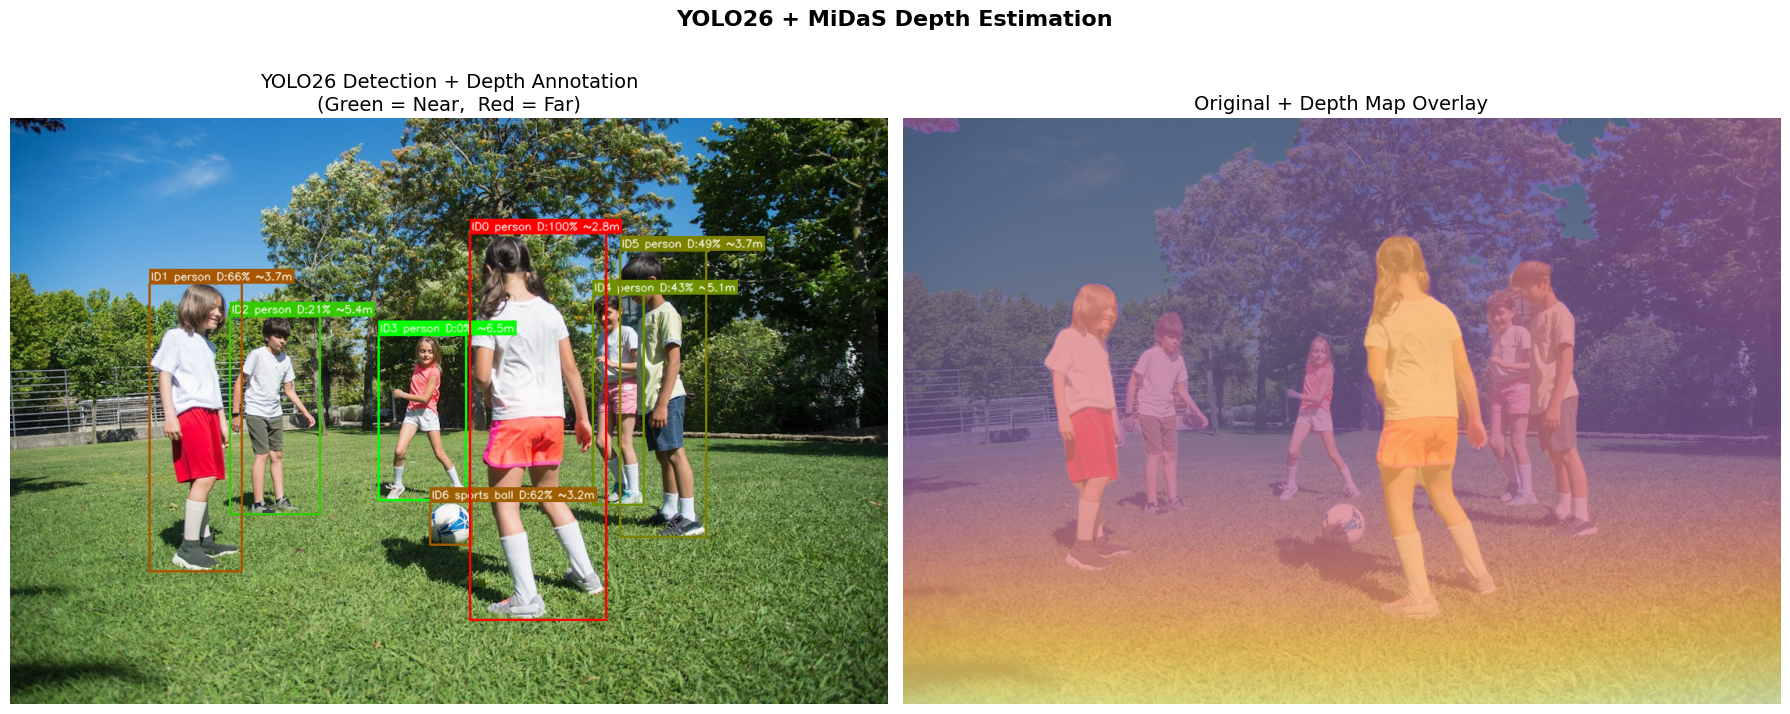

In [20]:
# Create annotated image
annotated = draw_depth_annotated_image(img_rgb, objects, depth_map)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Detection + Depth Annotation
axes[0].imshow(annotated)
axes[0].set_title("YOLO26 Detection + Depth Annotation\n(Green = Near,  Red = Far)", fontsize=14)
axes[0].axis("off")

# Depth Map overlay
depth_normalized_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
axes[1].imshow(img_rgb, alpha=0.5)
axes[1].imshow(depth_normalized_map, cmap="inferno", alpha=0.5)
axes[1].set_title("Original + Depth Map Overlay", fontsize=14)
axes[1].axis("off")

plt.suptitle("YOLO26 + MiDaS Depth Estimation", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## Part 8: Depth-based Object Sorting & Visualization

Categorize objects by distance: Near, Mid, Far

In [21]:
def categorize_by_depth(objects):
    """Split objects into 3 groups by depth"""
    near = [o for o in objects if o["depth_normalized"] < 33]
    mid  = [o for o in objects if 33 <= o["depth_normalized"] < 66]
    far  = [o for o in objects if o["depth_normalized"] >= 66]
    return near, mid, far


near_objects, mid_objects, far_objects = categorize_by_depth(objects)

print("=" * 60)
print("  Object Distance Categorization")
print("=" * 60)

print(f"\n  [NEAR] — {len(near_objects)} objects:")
for o in near_objects:
    dist_str = f", ~{o['estimated_distance_m']:.1f}m" if o.get("estimated_distance_m") else ""
    print(f"    - ID{o['obj_id']} {o['class']} (conf: {o['confidence']:.2f}, "
          f"depth: {o['depth_normalized']:.1f}%{dist_str})")

print(f"\n  [MID] — {len(mid_objects)} objects:")
for o in mid_objects:
    dist_str = f", ~{o['estimated_distance_m']:.1f}m" if o.get("estimated_distance_m") else ""
    print(f"    - ID{o['obj_id']} {o['class']} (conf: {o['confidence']:.2f}, "
          f"depth: {o['depth_normalized']:.1f}%{dist_str})")

print(f"\n  [FAR] — {len(far_objects)} objects:")
for o in far_objects:
    dist_str = f", ~{o['estimated_distance_m']:.1f}m" if o.get("estimated_distance_m") else ""
    print(f"    - ID{o['obj_id']} {o['class']} (conf: {o['confidence']:.2f}, "
          f"depth: {o['depth_normalized']:.1f}%{dist_str})")

  Object Distance Categorization

  [NEAR] — 2 objects:
    - ID3 person (conf: 0.90, depth: 0.0%, ~6.5m)
    - ID2 person (conf: 0.90, depth: 20.5%, ~5.4m)

  [MID] — 4 objects:
    - ID4 person (conf: 0.86, depth: 43.0%, ~5.1m)
    - ID5 person (conf: 0.85, depth: 49.0%, ~3.7m)
    - ID6 sports ball (conf: 0.81, depth: 62.4%, ~3.2m)
    - ID1 person (conf: 0.91, depth: 65.7%, ~3.7m)

  [FAR] — 1 objects:
    - ID0 person (conf: 0.92, depth: 100.0%, ~2.8m)


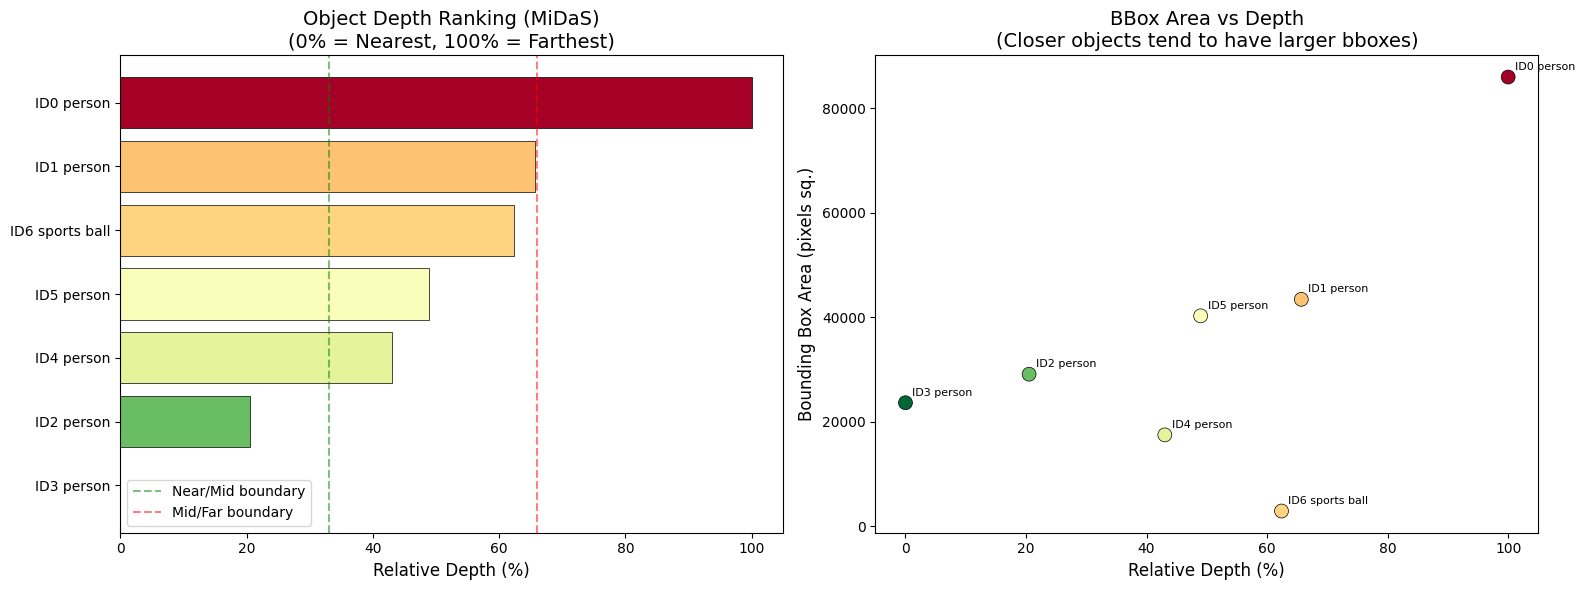

In [22]:
# Charts: Depth ranking + BBox Area vs Depth
if objects:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    labels = [f"ID{o['obj_id']} {o['class']}" for o in objects]
    depths = [o["depth_normalized"] for o in objects]

    # Bar chart — MiDaS relative depth
    colors = [plt.cm.RdYlGn_r(d / 100.0) for d in depths]
    bars = axes[0].barh(labels, depths, color=colors, edgecolor="black", linewidth=0.5)
    axes[0].set_xlabel("Relative Depth (%)", fontsize=12)
    axes[0].set_title("Object Depth Ranking (MiDaS)\n(0% = Nearest, 100% = Farthest)", fontsize=14)
    axes[0].axvline(x=33, color="green", linestyle="--", alpha=0.5, label="Near/Mid boundary")
    axes[0].axvline(x=66, color="red", linestyle="--", alpha=0.5, label="Mid/Far boundary")
    axes[0].legend()
    axes[0].set_xlim(0, 105)

    # Scatter plot: BBox Area vs Depth
    areas = [o["bbox_area"] for o in objects]
    axes[1].scatter(depths, areas, c=colors, s=100, edgecolors="black", linewidth=0.5)
    for o in objects:
        axes[1].annotate(f"ID{o['obj_id']} {o['class']}",
                         (o["depth_normalized"], o["bbox_area"]),
                         textcoords="offset points", xytext=(5, 5), fontsize=8)
    axes[1].set_xlabel("Relative Depth (%)", fontsize=12)
    axes[1].set_ylabel("Bounding Box Area (pixels sq.)", fontsize=12)
    axes[1].set_title("BBox Area vs Depth\n(Closer objects tend to have larger bboxes)", fontsize=14)

    plt.tight_layout()
    plt.show()

## Part 9: Compare MiDaS vs BBox Distance Estimation

How well does the simple BBox heuristic correlate with MiDaS depth?

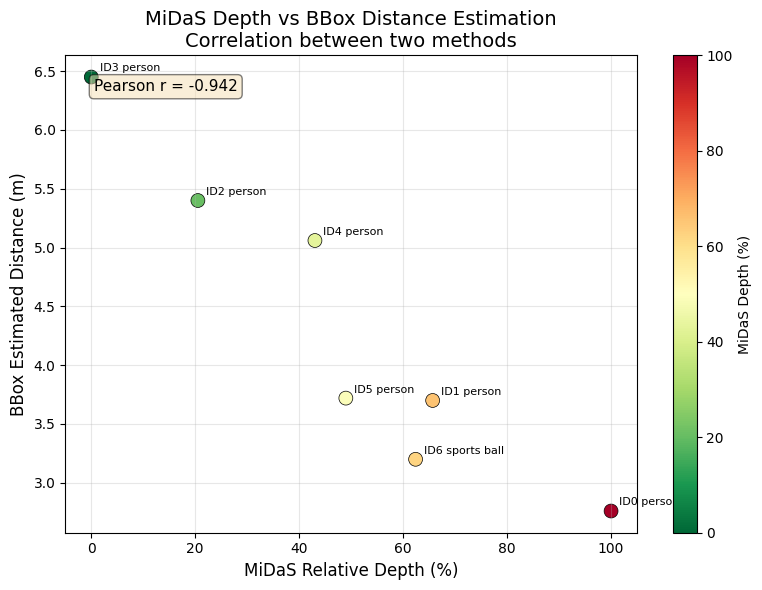


  Pearson correlation between MiDaS depth and BBox distance: -0.942
  -> Weak correlation: methods give different depth ordering.


In [23]:
if objects:
    # Gather paired data
    midas_depths = []
    bbox_dists = []
    obj_labels = []

    for obj in objects:
        if obj.get("estimated_distance_m") is not None:
            midas_depths.append(obj["depth_normalized"])
            bbox_dists.append(obj["estimated_distance_m"])
            obj_labels.append(f"ID{obj['obj_id']} {obj['class']}")

    if len(midas_depths) >= 2:
        fig, ax = plt.subplots(figsize=(8, 6))

        scatter = ax.scatter(midas_depths, bbox_dists, s=100,
                             c=midas_depths, cmap="RdYlGn_r",
                             edgecolors="black", linewidth=0.5)

        for lbl, x, y in zip(obj_labels, midas_depths, bbox_dists):
            ax.annotate(lbl, (x, y), textcoords="offset points", xytext=(6, 4), fontsize=8)

        ax.set_xlabel("MiDaS Relative Depth (%)", fontsize=12)
        ax.set_ylabel("BBox Estimated Distance (m)", fontsize=12)
        ax.set_title("MiDaS Depth vs BBox Distance Estimation\nCorrelation between two methods", fontsize=14)
        ax.grid(True, alpha=0.3)

        # Compute correlation
        corr = np.corrcoef(midas_depths, bbox_dists)[0, 1]
        ax.text(0.05, 0.95, f"Pearson r = {corr:.3f}",
                transform=ax.transAxes, fontsize=11, verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
        plt.colorbar(scatter, label="MiDaS Depth (%)")
        plt.tight_layout()
        plt.show()

        print(f"\n  Pearson correlation between MiDaS depth and BBox distance: {corr:.3f}")
        if corr > 0.7:
            print("  -> Strong positive correlation: both methods agree well.")
        elif corr > 0.3:
            print("  -> Moderate correlation: partial agreement between methods.")
        else:
            print("  -> Weak correlation: methods give different depth ordering.")
    else:
        print("  Not enough data points for correlation analysis.")

## Part 10: Video Processing — Frame-by-Frame Detection + Depth

Apply detection + depth estimation frame by frame on video.

In [24]:
def process_video_with_depth(video_path, yolo_model, midas_model, midas_transform,
                             device, max_frames=30, conf_threshold=0.4):
    """
    Process video: YOLO26 detection + MiDaS depth estimation

    Parameters:
    -----------
    video_path : str — path to video file
    yolo_model : YOLO model
    midas_model : MiDaS model
    midas_transform : MiDaS preprocessing transform
    device : torch.device
    max_frames : int — maximum frames to process
    conf_threshold : float — confidence threshold for YOLO

    Returns:
    --------
    list of dict — results per frame
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Cannot open video: {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Video: {total_frames} frames, {fps:.1f} FPS")
    print(f"Processing {min(max_frames, total_frames)} frames...")

    frame_results = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # YOLO26 Detection
        yolo_results = yolo_model(frame_rgb, imgsz=640, conf=conf_threshold, verbose=False)

        # MiDaS Depth Estimation
        input_batch = midas_transform(frame_rgb).to(device)
        with torch.no_grad():
            depth_pred = midas_model(input_batch)
            depth_pred = torch.nn.functional.interpolate(
                depth_pred.unsqueeze(1),
                size=frame_rgb.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depth_frame = depth_pred.cpu().numpy()

        # Compute depth of each object (depth_normalized is now included!)
        result_frame = yolo_results[0]
        frame_objects = estimate_object_depth(
            result_frame.boxes, depth_frame, result_frame.names, method="median"
        )

        frame_results.append({
            "frame_id": frame_count,
            "num_objects": len(frame_objects),
            "objects": frame_objects,
            "depth_map": depth_frame,
            "frame_rgb": frame_rgb,
        })

        frame_count += 1
        if frame_count % 10 == 0:
            print(f"  Frame {frame_count}/{min(max_frames, total_frames)}")

    cap.release()
    print(f"Processing complete: {frame_count} frames")
    return frame_results

## Part 10.5: Video Display with MiDaS in Jupyter (Bonus)

Display video with real-time MiDaS depth map side-by-side in a Jupyter notebook.

In [25]:
# ============================================================
# Display video with MiDaS depth estimation in Jupyter
# Modify this video path to your own video file
# ============================================================

from IPython.display import display, Image as IPImage, clear_output

cap = cv2.VideoCapture(".././videos/video5.mp4")

if not cap.isOpened():
    print("Cannot open video file")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Stream stopped.")
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # --- MiDaS depth estimation ---
        input_batch = transform(frame_rgb).to(device)
        with torch.no_grad():
            prediction = midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=frame_rgb.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depth_frame = prediction.cpu().numpy()

        # --- Normalize depth to 0-255 for visualization ---
        depth_norm = cv2.normalize(depth_frame, None, 0, 255, cv2.NORM_MINMAX)
        depth_uint8 = depth_norm.astype(np.uint8)
        depth_color = cv2.applyColorMap(depth_uint8, cv2.COLORMAP_INFERNO)

        # --- Stack original + depth side by side ---
        frame_resized = cv2.resize(frame, (depth_color.shape[1], depth_color.shape[0]))
        combined = np.hstack([frame_resized, depth_color])

        # --- Display in Jupyter ---
        _, buffer = cv2.imencode('.jpg', combined)
        img_bytes = buffer.tobytes()
        display(IPImage(data=img_bytes))
        clear_output(wait=True)

    cap.release()
    print("Video stream ended.")

print("Video display with MiDaS is ready!")
print("Uncomment the code above when you have a video file.")

Stream stopped.
Video stream ended.
Video display with MiDaS is ready!
Uncomment the code above when you have a video file.


In [26]:
# %%
# ============================================================
# Display video with YOLO26 + MiDaS + Distance Ranking Panel (Left)
# Layout: [Distance Panel] | [Annotated Video] | [Depth Map]
# ============================================================
from IPython.display import display, Image as IPImage, clear_output

VIDEO_PATH = ".././videos/video5.mp4"
CONF_THRESHOLD = 0.4
PANEL_WIDTH = 280  # Width of left distance panel

cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print("Cannot open video file")
else:
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Stream stopped.")
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h_frame, w_frame = frame_rgb.shape[:2]

        # --- YOLO26 Detection ---
        yolo_results = model(frame_rgb, imgsz=640, conf=CONF_THRESHOLD, verbose=False)
        result_frame = yolo_results[0]

        # --- MiDaS depth estimation ---
        input_batch = transform(frame_rgb).to(device)
        with torch.no_grad():
            prediction = midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=frame_rgb.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depth_frame = prediction.cpu().numpy()

        # --- Compute per-object depth (includes depth_normalized) ---
        frame_objects = estimate_object_depth(
            result_frame.boxes, depth_frame, result_frame.names, method="median"
        )

        # --- Merge BBox distance ---
        for obj in frame_objects:
            real_h = KNOWN_HEIGHTS_M.get(obj["class"], DEFAULT_HEIGHT_M)
            bbox_h = obj["bbox"][3] - obj["bbox"][1]
            if bbox_h > 0:
                obj["estimated_distance_m"] = round(
                    (real_h * ASSUMED_FOCAL_LENGTH_PX) / bbox_h, 2
                )
            else:
                obj["estimated_distance_m"] = None

        # Sort by distance (nearest first)
        sorted_objects = sorted(
            frame_objects,
            key=lambda o: o.get("estimated_distance_m") or 999,
        )

        # Distance range for normalization
        all_dists = [
            o["estimated_distance_m"]
            for o in frame_objects
            if o.get("estimated_distance_m") is not None
        ]
        if all_dists:
            dist_min, dist_max = min(all_dists), max(all_dists)
        else:
            dist_min, dist_max = 0, 1
        dist_range = dist_max - dist_min if dist_max > dist_min else 1.0

        # ============================================================
        # 1) Draw annotated video frame (BGR)
        # ============================================================
        annotated_bgr = frame.copy()

        for obj in frame_objects:
            x1, y1, x2, y2 = obj["bbox"]
            depth_pct = obj["depth_normalized"]
            dist_m = obj.get("estimated_distance_m")

            norm = depth_pct / 100.0
            color_bgr = (0, int(255 * (1 - norm)), int(255 * norm))

            # Bounding box
            cv2.rectangle(annotated_bgr, (x1, y1), (x2, y2), color_bgr, 2)

            # Label
            dist_str = f" ~{dist_m:.1f}m" if dist_m is not None else ""
            label = f"ID{obj['obj_id']} {obj['class']}{dist_str}"
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.45, 1)
            cv2.rectangle(annotated_bgr, (x1, y1 - th - 8), (x1 + tw + 4, y1), color_bgr, -1)
            cv2.putText(
                annotated_bgr, label, (x1 + 2, y1 - 4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1, cv2.LINE_AA,
            )

            # Distance bar below bbox
            bar_y_top = min(y2 + 4, h_frame - 14)
            bar_y_bot = min(bar_y_top + 10, h_frame - 2)
            bar_max_w = max(40, x2 - x1)
            if dist_m is not None and dist_range > 0:
                fill_ratio = 1.0 - min(1.0, (dist_m - dist_min) / dist_range)
            else:
                fill_ratio = 1.0 - norm
            bar_fill_w = max(4, int(bar_max_w * fill_ratio))
            cv2.rectangle(annotated_bgr, (x1, bar_y_top), (x1 + bar_max_w, bar_y_bot), (40, 40, 40), -1)
            cv2.rectangle(annotated_bgr, (x1, bar_y_top), (x1 + bar_fill_w, bar_y_bot), color_bgr, -1)
            cv2.rectangle(annotated_bgr, (x1, bar_y_top), (x1 + bar_max_w, bar_y_bot), (200, 200, 200), 1)

        # Frame info
        info_text = f"Frame {frame_idx} | Objects: {len(frame_objects)}"
        cv2.putText(annotated_bgr, info_text, (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

        # ============================================================
        # 2) Build LEFT PANEL — Distance Ranking
        # ============================================================
        panel = np.zeros((h_frame, PANEL_WIDTH, 3), dtype=np.uint8)
        panel[:] = (30, 30, 30)  # dark background

        # --- Panel title ---
        cv2.putText(panel, "DISTANCE RANKING", (10, 28),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.line(panel, (10, 36), (PANEL_WIDTH - 10, 36), (100, 100, 100), 1)

        # --- Column headers ---
        header_y = 56
        cv2.putText(panel, "ID", (10, header_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (180, 180, 180), 1, cv2.LINE_AA)
        cv2.putText(panel, "Class", (40, header_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (180, 180, 180), 1, cv2.LINE_AA)
        cv2.putText(panel, "Dist", (115, header_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (180, 180, 180), 1, cv2.LINE_AA)
        cv2.putText(panel, "Bar", (160, header_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (180, 180, 180), 1, cv2.LINE_AA)
        cv2.line(panel, (10, header_y + 6), (PANEL_WIDTH - 10, header_y + 6), (80, 80, 80), 1)

        # --- Object rows ---
        ROW_HEIGHT = 32
        BAR_MAX_W = 90
        start_y = header_y + 20
        max_rows = (h_frame - start_y - 50) // ROW_HEIGHT

        for rank, obj in enumerate(sorted_objects[:max_rows]):
            row_y = start_y + rank * ROW_HEIGHT
            depth_pct = obj["depth_normalized"]
            dist_m = obj.get("estimated_distance_m")
            norm = depth_pct / 100.0

            # Row color (near=green, far=red)
            r_val = int(255 * norm)
            g_val = int(255 * (1 - norm))
            color_bgr = (0, g_val, r_val)

            # Zone indicator dot
            cv2.circle(panel, (16, row_y + 4), 5, color_bgr, -1)
            cv2.circle(panel, (16, row_y + 4), 5, (200, 200, 200), 1)

            # Rank number
            # cv2.putText(panel, f"{rank+1}.", (8, row_y + 6),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.35, (150, 150, 150), 1, cv2.LINE_AA)

            # ID
            cv2.putText(panel, f"ID{obj['obj_id']}", (26, row_y + 6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.38, (255, 255, 255), 1, cv2.LINE_AA)

            # Class name (truncate if too long)
            cls_name = obj["class"][:8]
            cv2.putText(panel, cls_name, (62, row_y + 6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.38, color_bgr, 1, cv2.LINE_AA)

            # Distance text
            if dist_m is not None:
                dist_text = f"{dist_m:.1f}m"
            else:
                dist_text = "N/A"
            cv2.putText(panel, dist_text, (115, row_y + 6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.38, (255, 255, 255), 1, cv2.LINE_AA)

            # Distance bar
            bar_x = 160
            bar_y1 = row_y - 5
            bar_y2 = row_y + 9

            if dist_m is not None and dist_range > 0:
                fill_ratio = 1.0 - min(1.0, (dist_m - dist_min) / dist_range)
            else:
                fill_ratio = 1.0 - norm
            bar_fill = max(3, int(BAR_MAX_W * fill_ratio))

            # Bar background
            cv2.rectangle(panel, (bar_x, bar_y1), (bar_x + BAR_MAX_W, bar_y2), (50, 50, 50), -1)
            # Bar fill
            cv2.rectangle(panel, (bar_x, bar_y1), (bar_x + bar_fill, bar_y2), color_bgr, -1)
            # Bar border
            cv2.rectangle(panel, (bar_x, bar_y1), (bar_x + BAR_MAX_W, bar_y2), (120, 120, 120), 1)

            # Separator line
            sep_y = row_y + ROW_HEIGHT // 2 + 4
            cv2.line(panel, (10, sep_y), (PANEL_WIDTH - 10, sep_y), (50, 50, 50), 1)

        # --- Legend at bottom of panel ---
        legend_y = h_frame - 40
        cv2.line(panel, (10, legend_y - 10), (PANEL_WIDTH - 10, legend_y - 10), (80, 80, 80), 1)

        # Near-Far gradient bar
        grad_x, grad_w = 10, PANEL_WIDTH - 20
        grad_y1, grad_y2 = legend_y, legend_y + 12
        for px in range(grad_w):
            ratio = px / grad_w
            cr = int(255 * ratio)
            cg = int(255 * (1 - ratio))
            cv2.line(panel, (grad_x + px, grad_y1), (grad_x + px, grad_y2), (0, cg, cr), 1)
        cv2.rectangle(panel, (grad_x, grad_y1), (grad_x + grad_w, grad_y2), (150, 150, 150), 1)

        cv2.putText(panel, "NEAR", (grad_x, grad_y2 + 14),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(panel, "FAR", (grad_x + grad_w - 26, grad_y2 + 14),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1, cv2.LINE_AA)

        # ============================================================
        # 3) Depth colormap
        # ============================================================
        depth_norm_vis = cv2.normalize(depth_frame, None, 0, 255, cv2.NORM_MINMAX)
        depth_uint8 = depth_norm_vis.astype(np.uint8)
        depth_color = cv2.applyColorMap(depth_uint8, cv2.COLORMAP_INFERNO)
        depth_resized = cv2.resize(depth_color, (w_frame, h_frame))

        # ============================================================
        # 4) Combine: [Panel] | [Annotated] | [Depth]
        # ============================================================
        combined = np.hstack([panel, annotated_bgr, depth_resized])

        # --- Display in Jupyter ---
        _, buffer = cv2.imencode(".jpg", combined, [cv2.IMWRITE_JPEG_QUALITY, 80])
        img_bytes = buffer.tobytes()
        display(IPImage(data=img_bytes))
        clear_output(wait=True)

        frame_idx += 1

    cap.release()
    print("Video stream ended.")

Stream stopped.
Video stream ended.


## Part 11: Compare MiDaS Models

Compare 3 MiDaS variants: DPT_Large, DPT_Hybrid, MiDaS_small

In [27]:
import time


def compare_midas_models(image_path, model_types=None):
    """
    Compare different MiDaS models.
    """
    if model_types is None:
        model_types = ["MiDaS_small"]  # Use small only for speed
        # model_types = ["MiDaS_small", "DPT_Hybrid", "DPT_Large"]  # full comparison

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results_compare = {}

    for mt in model_types:
        print(f"\nLoading {mt}...")
        m = torch.hub.load("intel-isl/MiDaS", mt)
        m.to(device)
        m.eval()

        t = torch.hub.load("intel-isl/MiDaS", "transforms")
        if mt in ["DPT_Large", "DPT_Hybrid"]:
            tf = t.dpt_transform
        else:
            tf = t.small_transform

        input_batch = tf(img_rgb).to(device)

        # Warm up
        with torch.no_grad():
            _ = m(input_batch)

        # Benchmark
        start = time.time()
        n_runs = 5
        for _ in range(n_runs):
            with torch.no_grad():
                pred = m(input_batch)
        elapsed = (time.time() - start) / n_runs

        pred = torch.nn.functional.interpolate(
            pred.unsqueeze(1), size=img_rgb.shape[:2],
            mode="bicubic", align_corners=False
        ).squeeze()

        depth = pred.cpu().numpy()
        results_compare[mt] = {
            "depth_map": depth,
            "time_ms": elapsed * 1000,
        }
        print(f"  {mt}: {elapsed*1000:.1f}ms/frame")

        # Free model memory
        del m
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return results_compare

In [28]:
# Compare (using small model only for speed)
#comparison = compare_midas_models(IMAGE_PATH, model_types=["MiDaS_small"])

# Uncomment for full comparison (uses more RAM):
comparison = compare_midas_models(IMAGE_PATH, model_types=["MiDaS_small", "DPT_Hybrid", "DPT_Large"])


Loading MiDaS_small...


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


  MiDaS_small: 18.3ms/frame

Loading DPT_Hybrid...


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid_384.pt


100%|██████████| 470M/470M [00:45<00:00, 10.7MB/s] 
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


  DPT_Hybrid: 40.6ms/frame

Loading DPT_Large...


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


  DPT_Large: 14.4ms/frame


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


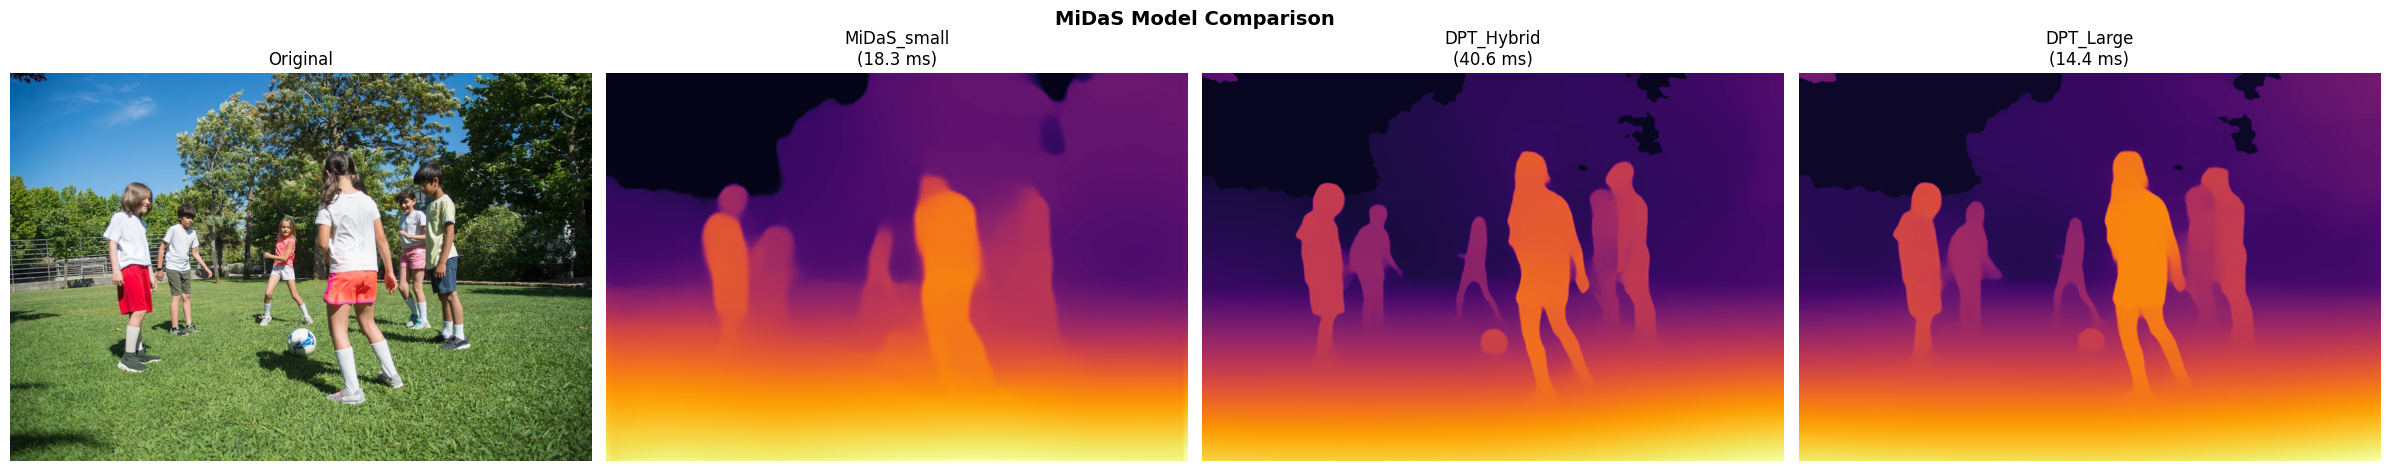

In [29]:
# Visualize comparison
n_models = len(comparison)
fig, axes = plt.subplots(1, n_models + 1, figsize=(6 * (n_models + 1), 5))

if n_models == 1:
    axes = [axes] if not isinstance(axes, np.ndarray) else axes.tolist()

ax0 = axes[0] if isinstance(axes, list) else axes[0]
ax0.imshow(img_rgb)
ax0.set_title("Original", fontsize=12)
ax0.axis("off")

for idx, (mt, data) in enumerate(comparison.items(), 1):
    ax = axes[idx] if isinstance(axes, list) else axes[idx]
    ax.imshow(data["depth_map"], cmap="inferno")
    ax.set_title(f"{mt}\n({data['time_ms']:.1f} ms)", fontsize=12)
    ax.axis("off")

plt.suptitle("MiDaS Model Comparison", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Part 12: Advanced — Depth-Aware Object Priority

### Use Case: ADAS (Advanced Driver Assistance System)
Closer objects → higher risk → alert first

In [30]:
def compute_danger_score(obj, weights=None):
    """
    Compute danger score of an object (for ADAS scenario).

    Objects that are close + large + human → very dangerous

    Parameters:
    -----------
    obj : dict — object info from estimate_object_depth
    weights : dict — weights for each factor

    Returns:
    --------
    float — danger score (0-100)
    """
    if weights is None:
        weights = {"proximity": 0.5, "size": 0.2, "class_risk": 0.3}

    # Proximity score (near = more danger) — invert depth
    proximity = 100 - obj["depth_normalized"]

    # Size score (larger = more danger)
    max_area = 500 * 500  # max value for normalization
    size_score = min(100, (obj["bbox_area"] / max_area) * 100)

    # Class risk (some classes are more dangerous)
    high_risk_classes = {
        "person": 100, "bicycle": 80, "motorcycle": 80, "car": 70,
        "bus": 60, "truck": 60, "dog": 70, "cat": 50,
    }
    class_risk = high_risk_classes.get(obj["class"], 30)

    # Weighted sum
    danger = (weights["proximity"] * proximity +
              weights["size"] * size_score +
              weights["class_risk"] * class_risk)

    return min(100, danger)

In [31]:
# Compute danger scores
if objects:
    for obj in objects:
        obj["danger_score"] = compute_danger_score(obj)

    # Sort by danger score (high = more dangerous)
    objects_by_danger = sorted(objects, key=lambda x: x["danger_score"], reverse=True)

    print("=" * 80)
    print("  DANGER SCORE RANKING (ADAS Scenario)")
    print("=" * 80)
    print(f"  {'Rank':>4} {'ID':>4} {'Class':>12} {'Depth%':>8} {'Area':>8} "
          f"{'Danger':>8} {'Alert':>10}")
    print("  " + "-" * 70)

    for rank, obj in enumerate(objects_by_danger, 1):
        danger = obj["danger_score"]
        if danger >= 70:
            alert = "!! HIGH"
        elif danger >= 40:
            alert = "!  MEDIUM"
        else:
            alert = "   LOW"
        print(f"  {rank:>4} {obj['obj_id']:>4} {obj['class']:>12} "
              f"{obj['depth_normalized']:>7.1f}% {obj['bbox_area']:>8} "
              f"{danger:>7.1f} {alert:>10}")

  DANGER SCORE RANKING (ADAS Scenario)
  Rank   ID        Class   Depth%     Area   Danger      Alert
  ----------------------------------------------------------------------
     1    3       person     0.0%    23632    81.9    !! HIGH
     2    2       person    20.5%    29095    72.1    !! HIGH
     3    4       person    43.0%    17485    59.9  !  MEDIUM
     4    5       person    49.0%    40260    58.7  !  MEDIUM
     5    1       person    65.7%    43424    50.6  !  MEDIUM
     6    0       person   100.0%    85956    36.9        LOW
     7    6  sports ball    62.4%     2915    28.0        LOW


## Part 13: Top-Down View (Bird's Eye View)

Display object positions from a top-down perspective.

In [32]:
def create_topdown_view(objects, img_width, img_height, figsize=(8, 10)):
    """
    Create top-down view showing x position (left-right) vs depth (near-far).
    """
    if not objects:
        print("No objects to display")
        return

    fig, ax = plt.subplots(figsize=figsize)

    for obj in objects:
        x1, y1, x2, y2 = obj["bbox"]
        cx = (x1 + x2) / 2  # center x
        depth_pct = obj["depth_normalized"]
        danger = obj.get("danger_score", 50)

        # Normalize x position (0-100)
        x_norm = (cx / img_width) * 100

        # Color by danger score
        color = plt.cm.RdYlGn_r(danger / 100)

        # Marker size by bbox area
        marker_size = max(50, min(500, obj["bbox_area"] / 100))

        ax.scatter(x_norm, depth_pct, s=marker_size, c=[color],
                   edgecolors="black", linewidth=1, zorder=5, alpha=0.8)

        dist_str = f"\n~{obj['estimated_distance_m']:.1f}m" if obj.get("estimated_distance_m") else ""
        ax.annotate(f"ID{obj['obj_id']} {obj['class']}\n(danger:{danger:.0f}){dist_str}",
                    (x_norm, depth_pct),
                    textcoords="offset points", xytext=(10, 5),
                    fontsize=8, ha="left")

    # Camera position (bottom)
    ax.scatter(50, -5, s=200, c="blue", marker="^", zorder=10, label="Camera")
    ax.annotate("Camera", (50, -5), textcoords="offset points",
                xytext=(0, -15), fontsize=10, ha="center", fontweight="bold")

    # Zone bands
    ax.axhspan(-10, 33, alpha=0.1, color="green", label="Near Zone")
    ax.axhspan(33, 66, alpha=0.1, color="yellow", label="Mid Zone")
    ax.axhspan(66, 110, alpha=0.1, color="red", label="Far Zone")

    ax.set_xlim(-5, 105)
    ax.set_ylim(-10, 110)
    ax.set_xlabel("Horizontal Position (Left to Right)", fontsize=12)
    ax.set_ylabel("Relative Depth (Near to Far)", fontsize=12)
    ax.set_title("Top-Down View (Bird's Eye View)\n"
                 "Each point = 1 detected object", fontsize=14)
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Near at top

    plt.tight_layout()
    plt.show()

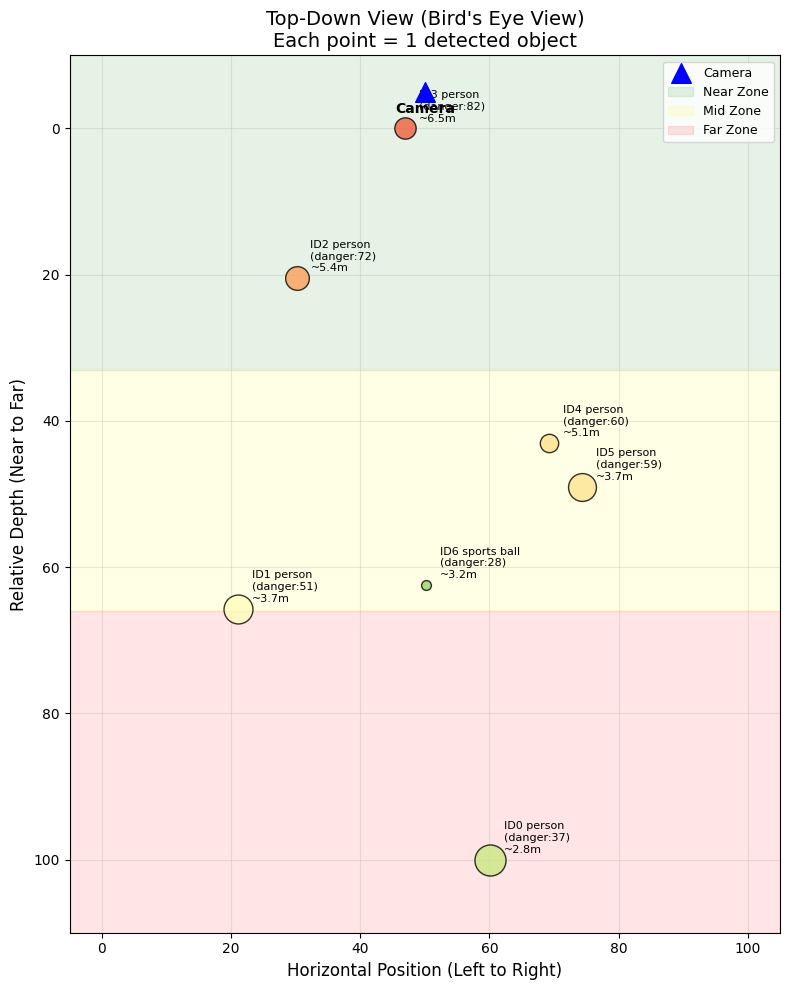

In [33]:
if objects:
    h, w = img_rgb.shape[:2]
    create_topdown_view(objects, w, h)

## Part 14: Summary and Exercises

### What We Learned in This Lab

1. **YOLO26** — Latest model from Ultralytics for real-time object detection
   - NMS-Free, DFL Removed, Edge Optimized
   - Supports Detection, Segmentation, Pose, OBB, Classification

2. **Object Distance Estimation (BBox Heuristic)** — NEW!
   - Uses pinhole camera model: Distance = (Real Height x Focal Length) / BBox Height
   - Gives **metric distance (meters)** — no extra model needed
   - Good complement to MiDaS relative depth

3. **MiDaS** — Monocular Depth Estimation from Intel Labs
   - Estimates relative depth from a single image
   - 3 variants: DPT_Large (accurate), DPT_Hybrid (balanced), MiDaS_small (fast)

4. **Combining YOLO + Depth** — Pseudo-3D Object Detection
   - Detect objects (2D) + estimate distance (Z-axis)
   - Two complementary methods: MiDaS (relative) + BBox heuristic (metric)
   - Applications: ADAS, Robotics, AR/VR, Surveillance

### Limitations

- MiDaS gives **relative depth** — not absolute distance (meters)
- BBox heuristic assumes known object sizes and estimated focal length
- Accuracy depends on scene complexity and camera calibration
- Additional calibration needed for precise metric depth

---

### Exercises

**Exercise 1:** Change MiDaS model to `DPT_Large` and compare depth map
with `MiDaS_small` — what differences do you observe?

**Exercise 2:** Use a larger YOLO26 model such as `yolo26s.pt` or `yolo26m.pt`
and compare number of detected objects.

**Exercise 3:** Try changing method in `estimate_object_depth()`
from "median" to "mean" or "center" — how do results differ?

**Exercise 4:** Use a different image with objects at multiple depth levels
(e.g., street scene, indoor room) and analyze depth estimation quality.

**Exercise 5 (Advanced):** Modify `compute_danger_score()` to include velocity
estimation by comparing depth between frames in video.

**Exercise 6 (New):** Calibrate the `ASSUMED_FOCAL_LENGTH_PX` value for your
specific camera. Compare BBox distance estimates before and after calibration.
How does focal length affect accuracy?

**Exercise 7 (New):** Add more classes to `KNOWN_HEIGHTS_M` dictionary and
test on images with those objects. Which classes give the most accurate
BBox distance estimates?

---

### References

- [Ultralytics YOLO26 Docs](https://docs.ultralytics.com/models/yolo26/)
- [MiDaS GitHub](https://github.com/isl-org/MiDaS)
- [MiDaS Paper: Towards Robust Monocular Depth Estimation (TPAMI 2022)](https://arxiv.org/abs/1907.01341)
- [Ultralytics Depth Estimation Guide](https://www.ultralytics.com/glossary/depth-estimation)
- [Pinhole Camera Model — OpenCV](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html)